In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

from skyfield.api import load, Topos
from datetime import datetime
from datetime import timedelta
from datetime import timezone

SAMPLE_RATE = 102400

d = pd.DataFrame

In [2]:
PWM_MIN = 5
PWM_MAX = 35

DURATION = 120

def deg_to_pwm(deg):
    return np.interp(deg, (0, 180), (PWM_MIN, PWM_MAX))

satellites = load.tle_file("active.txt")
sats = { sat.name: sat for sat in satellites }

data = {
    "lat": "32.4907 N",
    "lon": "45.8304 E",
    "start_time": 1586249863.726371
}

gs = Topos(data["lat"], data["lon"])

basetime = datetime.utcfromtimestamp(data["start_time"]).replace(tzinfo=timezone.utc)
times = [basetime + timedelta(seconds=i) for i in range(DURATION)]
ts = load.timescale()

def calc_pwm(sat):
    out_az = []
    out_alt = []
    
    t = ts.utc(times)

    topocentric = (sat - gs).at(t)

    alt, az, distance = topocentric.altaz()

    alt = alt.degrees
    az = az.degrees

    # satellite is not visible, exclude it
    for val in alt:
        if val < 0 or val > 180:
            return False, [], []

    for i, val in enumerate(az):
        if val > 180:
            az[i] -= 180
            alt[i] = 180 - alt[i]

    az_pwm = deg_to_pwm(az)
    alt_pwm = deg_to_pwm(alt)
    
    return True, az_pwm, alt_pwm

Compute azimuth and altitude for the 3 sample satellites we were given

In [3]:
sat_pwm = []
for sat_name in ["CANX-7", "STARLINK-1113", "SORTIE"]:
    succeed, az, alt = calc_pwm(sats[sat_name])
    if not succeed:
        raise Exception(f'Failed to compute PWM for {sat_name}')
    
    sat_pwm.append(pd.concat((pd.Series(az), pd.Series(alt)), axis="columns").rename(columns={0: "az", 1: "alt"}))

We're going to experiment with signal 2 because of that large change from t=12s to t=13s, it should make it easier to spot any patterns in the data

In [4]:
pd.set_option('display.max_rows', len(sat_pwm[2]))
display(sat_pwm[2])
pd.reset_option('display.max_rows')

,az,alt
0,33.855021,29.367168
1,33.954877,29.401771
2,34.053354,29.436611
3,34.150461,29.471668
4,34.246207,29.506921
5,34.340603,29.542351
6,34.433658,29.577938
7,34.525389,29.613667
8,34.615801,29.649516
9,34.704909,29.685469


In [5]:
def load_signal(fname):
    dtype = np.dtype([
        ("az", np.float32),
        ("alt", np.float32)
    ])

    data = np.fromfile(f'{fname}.bin', dtype)
    return pd.DataFrame(data)

def perform_fft(fft_data):
    fft = abs(np.fft.rfft(fft_data))
    fft = fft[:int(len(fft)/2)]
    fft_freq = np.fft.fftfreq(len(fft_data), 1/SAMPLE_RATE)
    
    return fft, fft_freq

In [6]:
signal2 = load_signal("signal_2")

Here, we made a guess that one of the n<sup>th</sup> multiple of 50Hz is related to the PWM duty cycle. Is that correct? First, lets identify the bin number we're interested in.

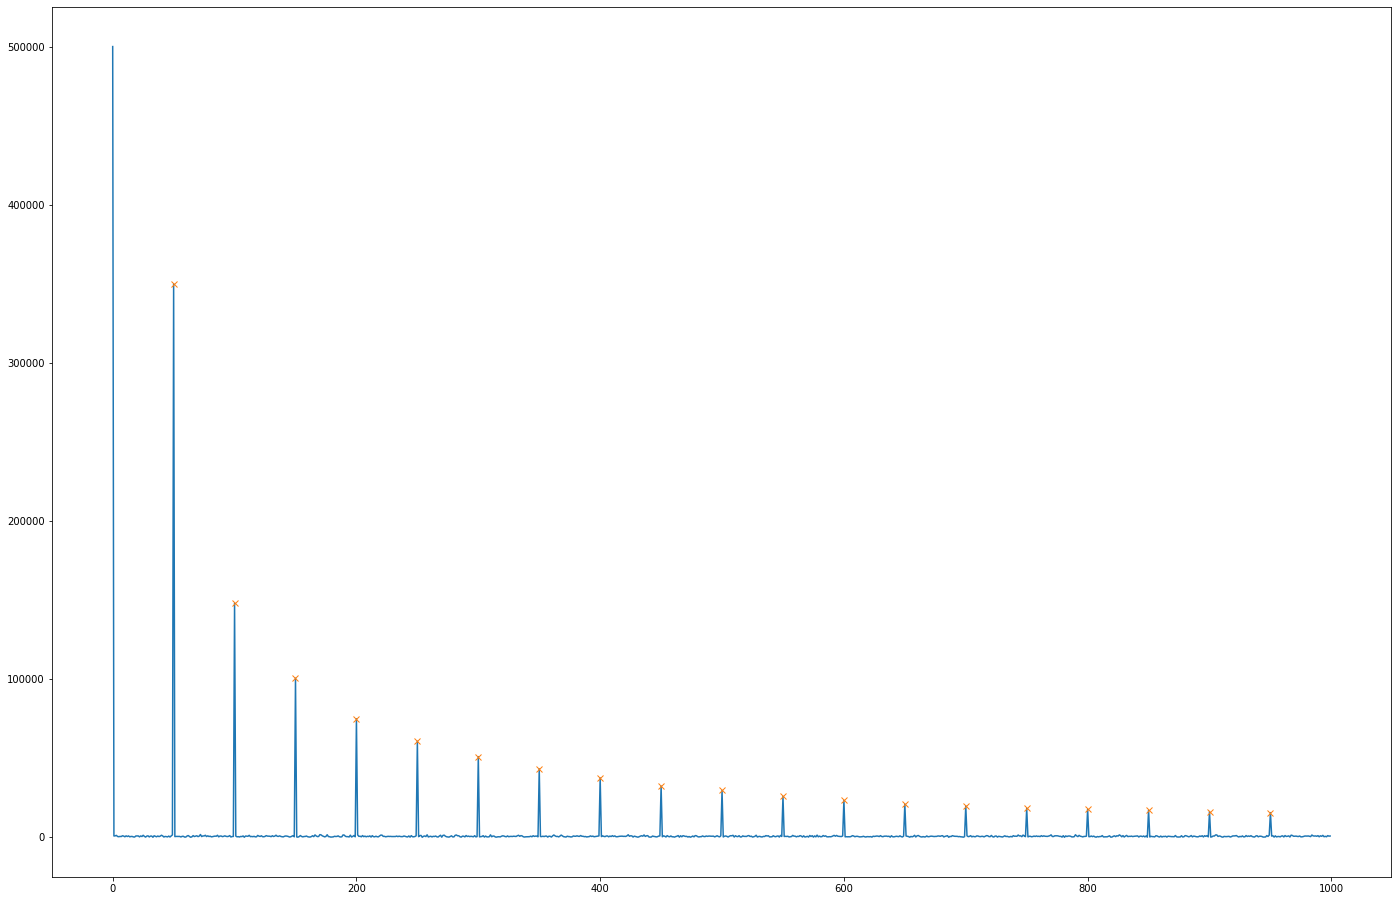

array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750, 800, 850, 900, 950])

In [7]:
fft, fft_freq = perform_fft(signal2["az"][14*SAMPLE_RATE:(14+1)*SAMPLE_RATE])

fft = fft[:1000]
fft_freq[:len(fft)]

peaks, _ =  find_peaks(fft, prominence=1000, height=10000)
plt.figure(figsize=(24, 16))
plt.plot(fft.clip(max=500000)) #  clip so that the DC value dosent overwhelm everything else
plt.plot(peaks, fft[peaks], "x")
plt.show()
display(peaks)

Here, we'll pick bin 100. How does this look when compared against the PWM values?

In [8]:
def compute_predictor(signal):
    predictors = {}
    for param in ("az", "alt"):
        amps = []
        for i in range(0, 120):
            fft, _ = perform_fft(signal[param][i*SAMPLE_RATE:(i+1)*SAMPLE_RATE])            
            amps.append(fft[100])
        
        predictors[param] = amps
    
    return pd.DataFrame(predictors)

In [9]:
predictor2 = compute_predictor(signal2)

In [10]:
a = pd.concat([predictor2["az"], sat_pwm[2]["az"]], axis="columns")
a.columns = ["harmonic", "pwm"]

In [11]:
pd.set_option('display.max_rows', len(a))
display(a)
pd.reset_option('display.max_rows')

,harmonic,pwm
0,145447.218506,33.855021
1,145435.393883,33.954877
2,145423.795181,34.053354
3,145412.370432,34.150461
4,145401.441906,34.246207
5,145390.777874,34.340603
6,145380.012272,34.433658
7,145374.282565,34.525389
8,145359.814524,34.615801
9,145354.387142,34.704909


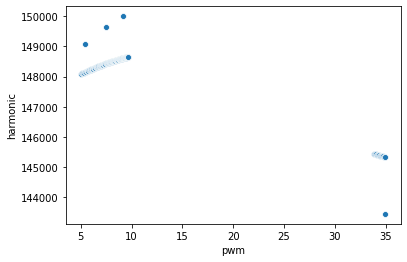

In [12]:
sb.scatterplot(x=a["pwm"], y=a["harmonic"])

Well, there is _some_ form of correlation, lets move on then. Lets smush together all the provided data and use it to train a linear regression model.

In [13]:
train_data = []
for i, fname in enumerate(["signal_0", "signal_1", "signal_2"]):
    predicted = compute_predictor(load_signal(fname))
    for param in ["az", "alt"]:
        a = pd.concat([predicted[param], sat_pwm[i][param]], axis="columns")
        a.columns = ["predictor", "pwm"]
        train_data.append(a)

train_df = pd.concat(train_data, ignore_index=True)

In [14]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(pd.DataFrame(train_df["predictor"]), train_df["pwm"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now, import the challenge (not example) files and predict the PWM values

In [15]:
live_signals = []
for fname in ["live_signal_0", "live_signal_1", "live_signal_2"]:
    raw_signal = compute_predictor(load_signal(fname))
    signal = pd.concat([d(reg.predict(d(raw_signal["az"]))), d(reg.predict(d(raw_signal["alt"])))], axis="columns")
    signal.columns = ["az", "alt"]
    live_signals.append(signal)

In [16]:
def plot_sat(data, label=""):
    az = data["az"]
    alt = data["alt"]
    fig, axs = plt.subplots(1, 2, figsize=(24, 8))
    
    sb.scatterplot(data=az, ax=axs[0])
    sb.scatterplot(data=alt, ax=axs[0])
    sb.scatterplot(x=az, y=alt, ax=axs[1])
    
    axs[0].set_xlabel("time")
    
    axs[1].set_xlabel("Az")
    axs[1].set_xlabel("Alt")
    fig.suptitle(label)
    plt.show()

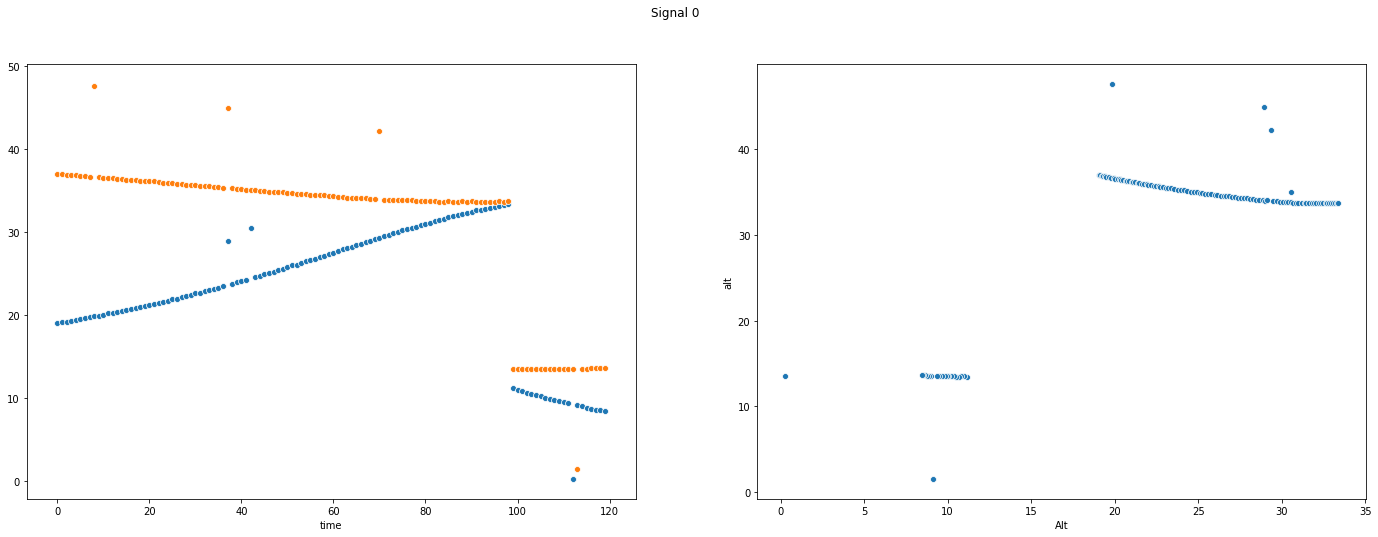

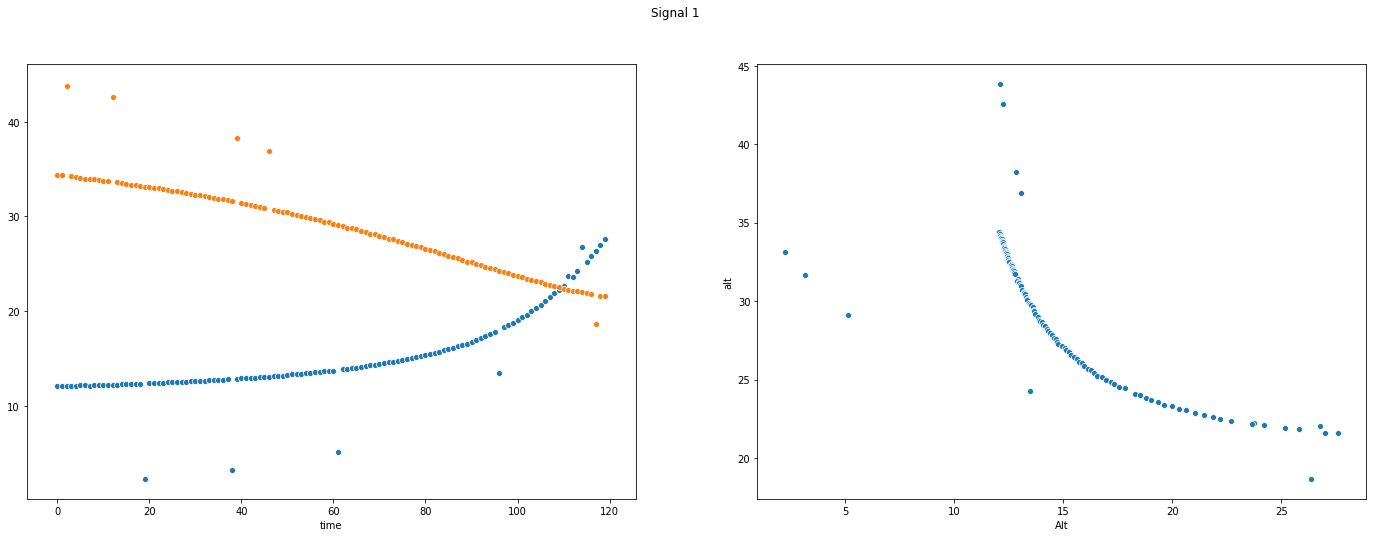

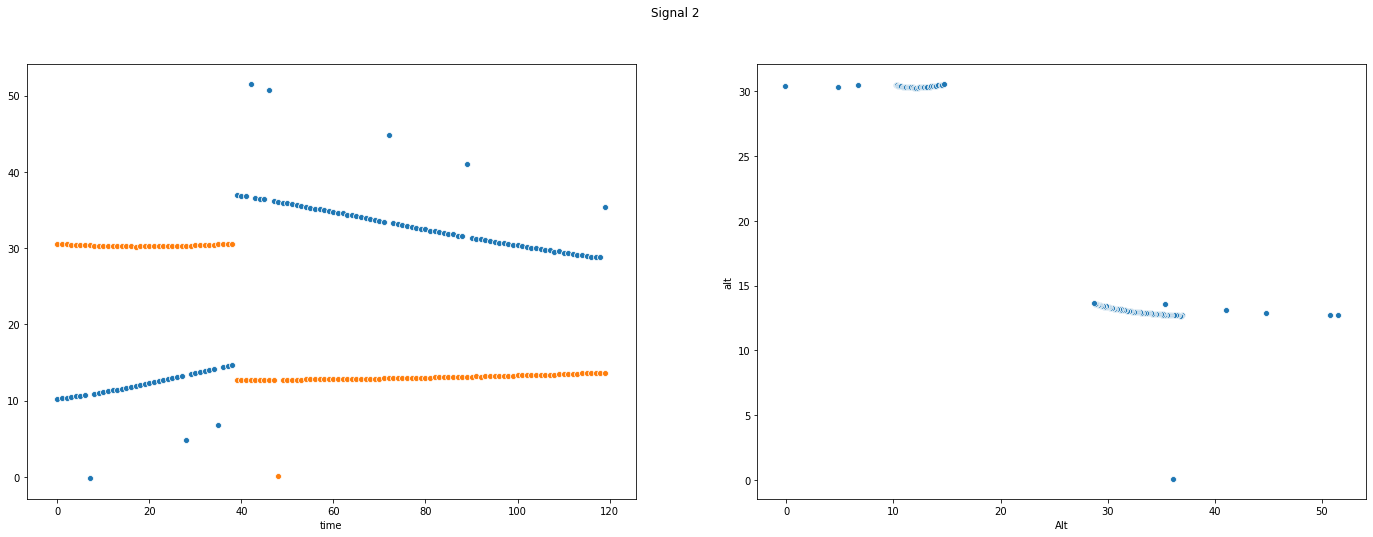

In [17]:
for i, signal in enumerate(live_signals):
    plot_sat(signal, label=f'Signal {i}')